In [ ]:
# ============================================
#               IMPORTS
# ============================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, precision_recall_curve, classification_report
)

from catboost import CatBoostClassifier


# ============================================
#               LOAD DATA
# ============================================
def load_data(path: str):
    df = pd.read_csv(path)
    return df


# ============================================
#        FEATURE ENGINEERING (MAIN)
# ============================================
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --- Fix numeric errors ---
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

    # =============================
    #       NEW FEATURES
    # =============================

    # 1) Count active services
    service_cols = [
        "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
        "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
    ]
    df["services_count"] = (df[service_cols] == "Yes").sum(axis=1)

    # 2) Payment ratio (monthly vs total)
    df["payment_ratio"] = df["MonthlyCharges"] / (df["TotalCharges"] + 1)

    # 3) Average charges per month of tenure
    df["avg_charges"] = df["TotalCharges"] / (df["tenure"] + 1)

    # 4) New client indicator
    df["is_new_client"] = (df["tenure"] <= 6).astype(int)

    # 5) Tenure groups
    df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[0, 6, 12, 24, 48, 72],
        labels=["0–6", "6–12", "12–24", "24–48", "48–72"],
        include_lowest=True
    )

    # 6) Contract + Payment interaction feature
    df["contract_payment"] = df["Contract"] + "_" + df["PaymentMethod"]

    return df


# ============================================
#             PREPARE X / y
# ============================================
def prepare_xy(df: pd.DataFrame, target="Churn"):
    df = df.copy()

    # Encode target
    y = df[target].replace({"No": 0, "Yes": 1})
    X = df.drop(columns=[target])

    return X, y


# ============================================
#           TRAIN/TEST SPLIT
# ============================================
def split_data(X, y, test_size=0.25):
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )


# ============================================
#             TRAIN CATBOOST
# ============================================
def train_catboost(X_train, y_train, cat_features):
    model = CatBoostClassifier(
        eval_metric="F1",
        random_seed=42,
        class_weights=[1, 2.7683],  # your class balance
        depth=6,
        learning_rate=0.05,
        iterations=500,
        l2_leaf_reg=9,
        border_count=32,
        bagging_temperature=2,
        verbose=0
    )

    model.fit(X_train, y_train, cat_features=cat_features)
    return model


# ============================================
#             EVALUATION
# ============================================
def evaluate(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]

    # Best threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    y_pred = (y_proba >= best_threshold).astype(int)

    print("\nFINAL CATBOOST RESULTS")
    print("----------------------")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1:        {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"\nBest threshold for F1: {best_threshold:.4f}\n")

    print(classification_report(y_test, y_pred))


    return best_threshold




In [21]:
def main():

    # 1) Load
    df = load_data("../data/cleaned_telecom_churn_data.csv")
    # 2) Feature Engineering
    df = create_features(df)
    print(df.columns.tolist())
    print(df.info())

    # 3) Prepare X/y
    X, y = prepare_xy(df)

    # 4) Detect categorical columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # 5) Train/Test split
    X_train, X_test, y_train, y_test = split_data(X, y)

    # 6) Train model
    model = train_catboost(X_train, y_train, cat_features)

    # 7) Evaluate & get threshold
    best_threshold = evaluate(model, X_test, y_test)

    # 8) SAVE MODEL
    model.save_model("catboost_churn_model.cbm")
    print("Model saved as catboost_churn_model.cbm")

    # 9) SAVE METADATA (features + threshold)
    feature_names = X_train.columns.tolist()


    # Create categorical feature indices (required by CatBoost)
    cat_feature_indices = [feature_names.index(c) for c in cat_features]

    metadata = {
        "cat_features": cat_features,
        "cat_feature_indices": cat_feature_indices,
        "feature_names": feature_names,
        "best_threshold": float(best_threshold)
    }


    with open("metadata.pkl", "wb") as f:
        pickle.dump(metadata, f)

    print("Metadata saved as metadata.pkl")


In [22]:
main()

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'services_count', 'payment_ratio', 'avg_charges', 'is_new_client', 'tenure_group', 'contract_payment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   int64   
 1   SeniorCitizen     7032 non-null   int64   
 2   Partner           7032 non-null   int64   
 3   Dependents        7032 non-null   int64   
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   int64   
 6   MultipleLines     7032 non-null   object  
 7   InternetService   7032 non-null   object  


TypeError: float() argument must be a string or a real number, not 'dict'

FINAL CATBOOST RESULTS
----------------------
Accuracy:  0.7728
F1:        0.6334
ROC-AUC:   0.8424
Precision: 0.5548
Recall:    0.7380

Best threshold for F1: 0.5715

In [19]:
# ============================================
#               IMPORTS
# ============================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, precision_recall_curve
)

from catboost import CatBoostClassifier


# ============================================
#               LOAD DATA
# ============================================
def load_data(path: str):
    df = pd.read_csv(path)
    return df


# ============================================
#        FEATURE ENGINEERING (MAIN)
# ============================================
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --- Fix numeric errors ---
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

    # =============================
    #       NEW FEATURES
    # =============================

    # 1) Count active services
    service_cols = [
        "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
        "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
    ]
    df["services_count"] = (df[service_cols] == "Yes").sum(axis=1)

    # 2) Payment ratio (monthly vs total)
    df["payment_ratio"] = df["MonthlyCharges"] / (df["TotalCharges"] + 1)

    # 3) Average charges per month of tenure
    df["avg_charges"] = df["TotalCharges"] / (df["tenure"] + 1)

    # 4) New client indicator
    df["is_new_client"] = (df["tenure"] <= 6).astype(int)

    # 5) Tenure groups
    df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[0, 6, 12, 24, 48, 72],
        labels=["0–6", "6–12", "12–24", "24–48", "48–72"],
        include_lowest=True
    )

    # 6) Contract + Payment interaction feature
    df["contract_payment"] = df["Contract"] + "_" + df["PaymentMethod"]

    return df


# ============================================
#             PREPARE X / y
# ============================================
def prepare_xy(df: pd.DataFrame, target="Churn"):
    df = df.copy()
    y = df[target].replace({"No": 0, "Yes": 1})
    X = df.drop(columns=[target])
    return X, y


# ============================================
#             TRAIN CATBOOST
# ============================================
def train_catboost(X_train, y_train, cat_features):
    model = CatBoostClassifier(
        eval_metric="F1",
        random_seed=42,
        class_weights=[1, 2.7683],
        depth=6,
        learning_rate=0.05,
        iterations=500,
        l2_leaf_reg=9,
        border_count=32,
        bagging_temperature=2,
        verbose=0
    )
    model.fit(X_train, y_train, cat_features=cat_features)
    return model


# ============================================
#             EVALUATION
# ============================================
def evaluate(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred = (y_proba >= best_threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "threshold": best_threshold
    }



# ============================================
#                   MAIN
# ============================================
def main():

    # 1) Load
    df = load_data("../data/cleaned_telecom_churn_data.csv")

    # 2) Feature Engineering
    df = create_features(df)

    # 3) Prepare X/y
    X, y = prepare_xy(df)

    # 4) Detect categorical columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # ============================================
    #        LOOP FOR TEST_SIZE 0.1 → 0.5
    # ============================================
    results = []

    for test_size in np.arange(0.1, 0.51, 0.01):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=42,
            stratify=y
        )

        model = train_catboost(X_train, y_train, cat_features)
        metrics = evaluate(model, X_test, y_test)
        metrics["test_size"] = round(test_size, 2)

        results.append(metrics)

        # print(f"✓ Done test_size={test_size:.2f}")

    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    print("\n=========== FINAL RESULTS ===========")
    print(df_results.sort_values("f1", ascending=False).reset_index(drop=True)[:10])
    print(df_results.sort_values("accuracy", ascending=False).reset_index(drop=True)[:10])
    print(df_results.sort_values("recall", ascending=False).reset_index(drop=True)[:10])




In [20]:
main()

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "accuracy": [0.784414,0.786088,0.777941,0.769952,0.761170,0.786156,0.760124,0.760664,0.757424,0.760506,
                 0.769820,0.766485,0.783965,0.772840,0.766106,0.802416,0.771564,0.751345,0.754502,0.760551,
                 0.756935,0.770762,0.794574,0.765618,0.771919,0.770183,0.758437,0.774543,0.779235,0.759347,
                 0.781991,0.751777,0.788310,0.733850,0.748223,0.749164,0.757617,0.762316,0.770833,0.743734,0.784091],
    "f1": [0.642790,0.639798,0.639044,0.638945,0.637931,0.637317,0.637044,0.635379,0.635220,0.634875,
           0.634866,0.633776,0.633624,0.633391,0.633303,0.633245,0.633181,0.633012,0.632624,0.632082,
           0.631634,0.631290,0.631090,0.630936,0.630872,0.630803,0.630435,0.630411,0.630037,0.628153,
           0.627646,0.626892,0.626741,0.625455,0.625378,0.625000,0.624738,0.624398,0.622754,0.620919,0.616162],
    "recall": [0.730193,0.715493,0.739852,0.765492,0.792049,0.706977,0.791860,0.785714,0.795276,0.783591,
               0.753086,0.759954,0.702823,0.737968,0.759825,0.641711,0.741533,0.806358,0.796429,0.774247,
               0.783572,0.738758,0.661800,0.753647,0.733556,0.739206,0.775920,0.723567,0.707819,0.764356,
               0.691358,0.783964,0.669643,0.834951,0.790076,0.786164,0.758270,0.743786,0.711443,0.790141,0.652406],
    "precision": [0.574074,0.578588,0.562412,0.548303,0.534021,0.580153,0.532864,0.533333,0.528796,0.533603,
                  0.548726,0.543531,0.576829,0.554774,0.542902,0.625000,0.552457,0.521008,0.524706,0.534025,
                  0.529049,0.551118,0.603104,0.542590,0.553406,0.550129,0.530892,0.558505,0.567657,0.533149,
                  0.574686,0.522255,0.589005,0.500000,0.517500,0.518672,0.531194,0.538036,0.553727,0.511395,0.583732],
    "test_size": [0.25,0.19,0.29,0.44,0.35,0.23,0.46,0.12,0.34,0.45,
                  0.26,0.47,0.36,0.40,0.49,0.20,0.30,0.37,0.15,0.32,
                  0.41,0.50,0.22,0.33,0.48,0.31,0.16,0.42,0.13,0.27,
                  0.39,0.24,0.18,0.11,0.14,0.17,0.21,0.28,0.43,0.38,0.10]
}

df = pd.DataFrame(data)


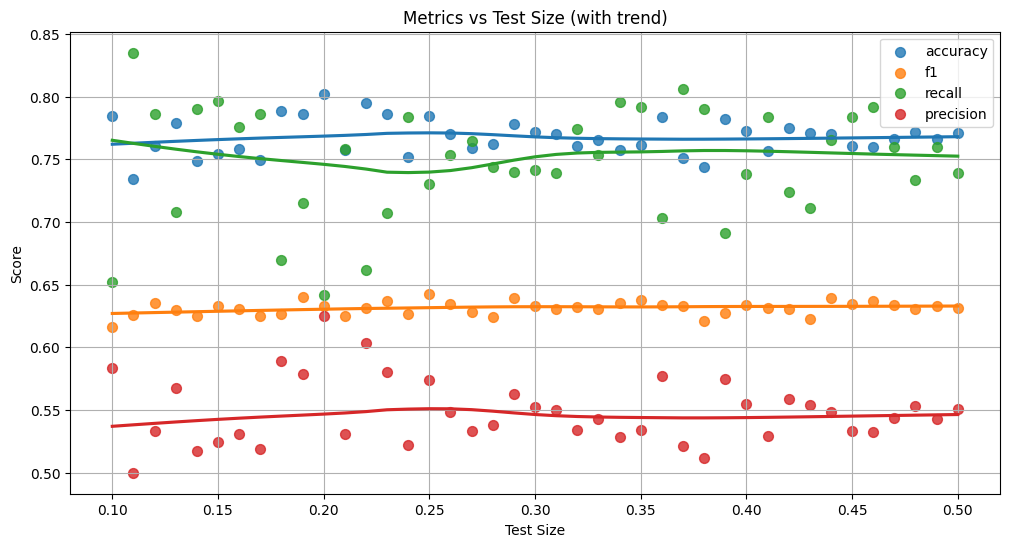

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,6))
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    sns.regplot(x='test_size', y=metric, data=df, label=metric, scatter_kws={'s':50}, lowess=True)

plt.xlabel('Test Size')
plt.ylabel('Score')
plt.title('Metrics vs Test Size (with trend)')
plt.legend()
plt.grid(True)
plt.show()

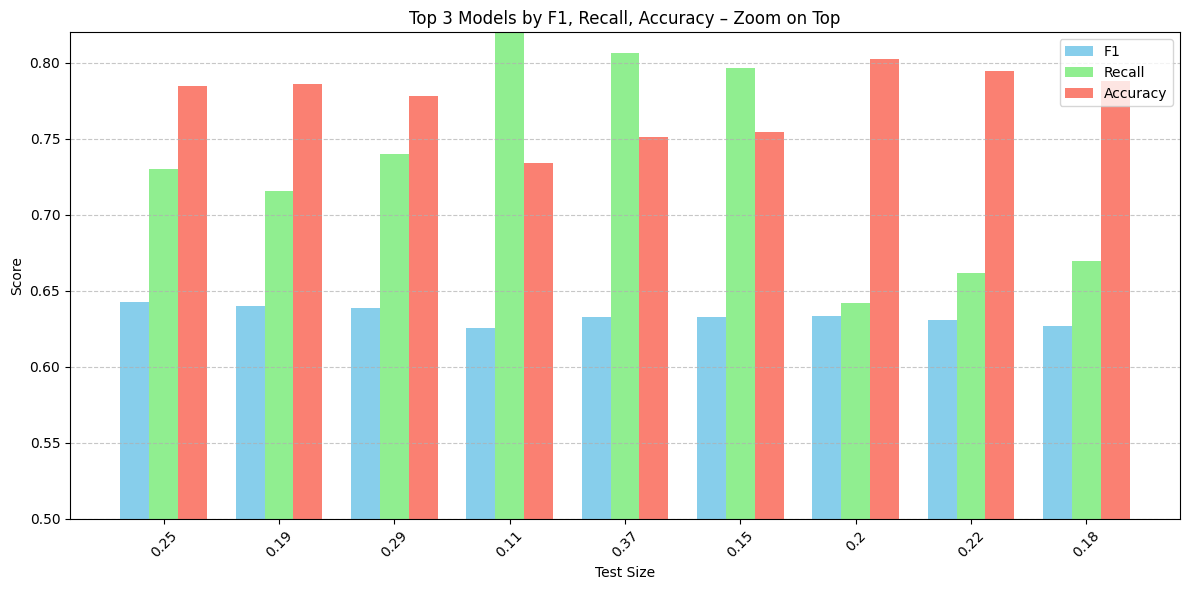

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

top_f1 = df.nlargest(3, 'f1')
top_recall = df.nlargest(3, 'recall')
top_accuracy = df.nlargest(3, 'accuracy')

top_combined = pd.concat([top_f1, top_recall, top_accuracy]).drop_duplicates().reset_index(drop=True)

indices = range(len(top_combined))
bar_width = 0.25

plt.figure(figsize=(12,6))

plt.bar([i - bar_width for i in indices], top_combined['f1'], width=bar_width, label='F1', color='skyblue')
plt.bar(indices, top_combined['recall'], width=bar_width, label='Recall', color='lightgreen')
plt.bar([i + bar_width for i in indices], top_combined['accuracy'], width=bar_width, label='Accuracy', color='salmon')

plt.xticks(indices, top_combined['test_size'], rotation=45)
plt.xlabel('Test Size')
plt.ylabel('Score')
plt.title('Top 3 Models by F1, Recall, Accuracy – Zoom on Top')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0.5, 0.82)

plt.tight_layout()
plt.show()

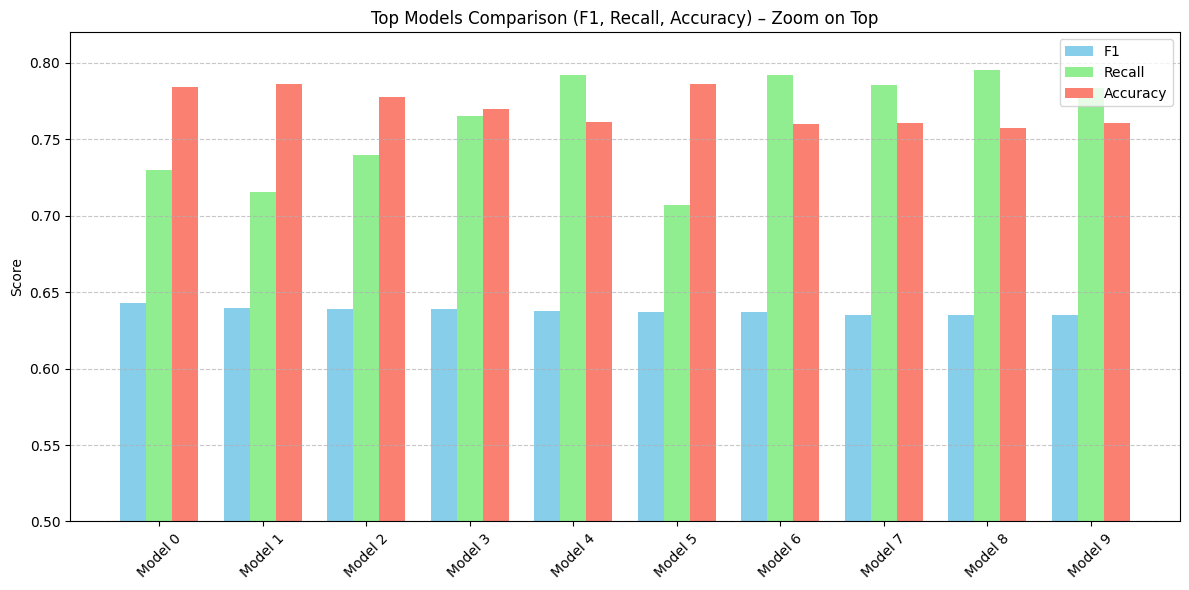

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Берём топ-10 по F1
top_df = df.sort_values(by='f1', ascending=False).head(10)

indices = range(len(top_df))

plt.figure(figsize=(12,6))

bar_width = 0.25

# Вертикальные бары
plt.bar([i - bar_width for i in indices], top_df['f1'], width=bar_width, label='F1', color='skyblue')
plt.bar(indices, top_df['recall'], width=bar_width, label='Recall', color='lightgreen')
plt.bar([i + bar_width for i in indices], top_df['accuracy'], width=bar_width, label='Accuracy', color='salmon')

# Подписи
plt.xticks(indices, [f"Model {i}" for i in top_df.index], rotation=45)
plt.ylabel('Score')
plt.title('Top Models Comparison (F1, Recall, Accuracy) – Zoom on Top')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ограничиваем ось Y, чтобы показывать только верхушки
plt.ylim(0.5, 0.82)  # минимальное значение = 0.5, максимальное чуть выше лучшей метрики

plt.tight_layout()
plt.show()